In [2]:
import keras
import keras.backend as K
import tensorflow as tf

import tensorflow as tf
from keras.layers import Input, Conv2D, MaxPooling3D, UpSampling3D, Activation, Dense, Multiply, Reshape, Flatten,Concatenate
from keras.layers import Conv2DTranspose, ConvLSTM2D, Lambda, Average, Bidirectional, Add, Dropout, GlobalMaxPool1D, GlobalAveragePooling2D, GlobalAveragePooling1D
from keras_layer_normalization import LayerNormalization
from keras.utils.generic_utils import get_custom_objects
from keras.models import Model
from tensorflow.keras.optimizers import Adam
import math
import time
import random
import h5py
import os
import re
import matplotlib.pyplot as plt
import numpy
import warnings
warnings.filterwarnings('ignore')

%matplotlib notebook

from scipy.io import savemat
from sklearn import metrics
from sklearn.metrics import classification_report

from model_design import *

# Organize data into bags of clinical image-patches

In [6]:
def generator(train_indices, lines, itr):
        batch_images = []
        batch_gt = []
        clips = []
        clips_gt = []
        clips_bag = []
        startInd = itr*batch_size
        endInd = startInd + batch_size
        clip = np.zeros(shape=(bag_size, 128, 128, 3))
        clip_gt = np.zeros(shape=(bag_size, 3))
        
        for i in range(startInd, endInd):
            startIfg = i*bag_size
            endIfg = startIfg + bag_size
            cnt = 0
            bag_label = [0,1]
            for j in range(startIfg, endIfg):
                folder_path = lines[np.int(train_indices[j])]
                #print(folder_path)
                index = [m.start() for m in re.finditer(' : ', folder_path)]
                #print(index)
                label_name = folder_path[index[0]+3:index[1]]
                #print(label_name)

                if label_name == 'dysplastic':     #dysplastic/pre-cancerous
                    gt = [1,0,0]
                    bag_label = [1,0]
                if label_name == 'cancerous':     #cancerous
                    gt = [0,1,0]
                    bag_label = [1,0]
                if label_name == 'non_dysplastic':    #control-cases
                    gt = [0,0,1]
                
                #print(startInd, endInd, folder_path)
                image_path = folder_path[0:index[0]]
                patch = plt.imread(image_path)
            
                clip[cnt, :, :, :] = patch
                clip_gt[cnt, :] = gt
                cnt = cnt  + 1
               
            clips.append(clip)
            clips_gt.append(clip_gt)
            clips_bag.append(bag_label)
            
        
        batch_images = np.array(clips, dtype=np.float32)
        batch_gt = np.array(clips_gt, dtype=np.int32)
        batch_gt_bag = np.array(clips_bag, dtype=np.int32)
       
        return batch_images, batch_gt, batch_gt_bag

# Load model files and run on test data for evaluation

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 128, 128, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 128, 128, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 64, 64, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 64, 64, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 64, 64, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 32, 32, 128)       0   

2023-11-14 04:28:50.844382: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


<IPython.core.display.Javascript object>


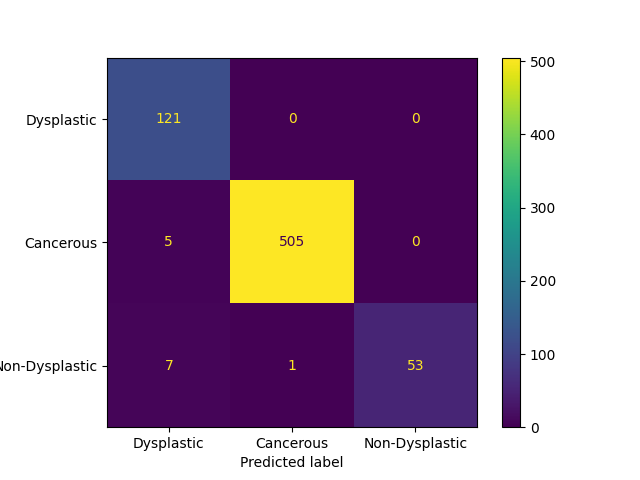

{'Accuracy': 0.9812138728323699, 'Precision': 0.9812138728323699, 'Sensitivity_recall': 0.9812138728323699, 'Specificity': 0.9812138728323699, 'F1_score': 0.9812138728323699}
              precision    recall  f1-score   support

           0       0.91      1.00      0.95       121
           1       1.00      0.99      0.99       510
           2       1.00      0.87      0.93        61

    accuracy                           0.98       692
   macro avg       0.97      0.95      0.96       692
weighted avg       0.98      0.98      0.98       692



<IPython.core.display.Javascript object>


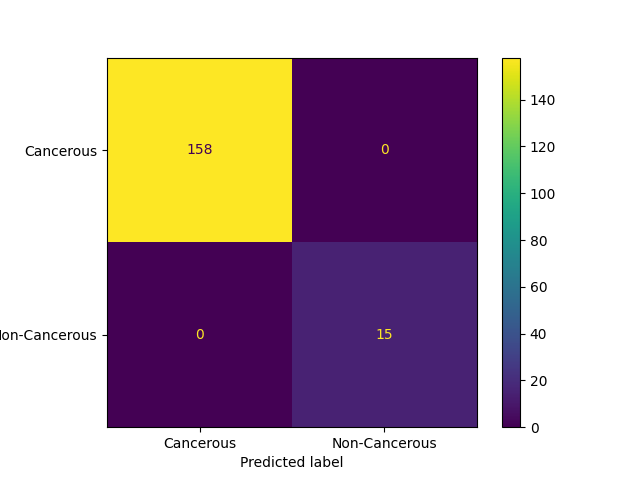

{'Accuracy': 1.0, 'Precision': 1.0, 'Sensitivity_recall': 1.0, 'Specificity': 1.0, 'F1_score': 1.0}
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       158
           1       1.00      1.00      1.00        15

    accuracy                           1.00       173
   macro avg       1.00      1.00      1.00       173
weighted avg       1.00      1.00      1.00       173



In [7]:
batch_size = 1
lines_test = [line.rstrip('\\n') for line in open('TEST_visualize_patches_non_overlapping.txt')]
all_indices_test = list(np.arange(len(lines_test)))

iterations_ts = np.int(len(all_indices_test)/ batch_size)
iterations_ts = np.int(iterations_ts / bag_size)
model = build_MIL_convnet(shape=(bag_size, 128, 128, 3))

file_name_model = "MIL_VGG_clinical.hdf5"
model.load_weights(file_name_model)

all_preds_fine = []
all_gt_fine = []
all_preds_bag = []
all_gt_bag = []
for i in range(0,iterations_ts):
        test_set, test_gt_fine, test_gt_bag = generator(all_indices_test,lines_test, i)
        preds_bag, preds_fine = model.predict(test_set)
        #print(preds_bag.shape, preds_fine.shape)
        for j in range(0,batch_size):
            pred_label_bag = np.argmax(preds_bag[j,:])
            gt_label_bag = np.argmax(test_gt_bag[j,:])
           
            all_preds_bag.append(pred_label_bag)
            all_gt_bag.append(gt_label_bag)
            for k in range(0, bag_size):
                pred_label_fine = np.argmax(preds_fine[j,k,:])
                gt_label_fine = np.argmax(test_gt_fine[j,k,:])
                
                all_preds_fine.append(pred_label_fine)
                all_gt_fine.append(gt_label_fine)

confusion_matrix = metrics.confusion_matrix(all_gt_fine, all_preds_fine)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = ['Dysplastic', 'Cancerous', 'Non-Dysplastic'])
cm_display.plot()
plt.show()

Accuracy = metrics.accuracy_score(all_gt_fine, all_preds_fine)
Precision = metrics.precision_score(all_gt_fine, all_preds_fine, average='micro')
Sensitivity_recall = metrics.recall_score(all_gt_fine, all_preds_fine,  average='micro')
Specificity = metrics.recall_score(all_gt_fine, all_preds_fine,  average='micro')
F1_score = metrics.f1_score(all_gt_fine, all_preds_fine,  average='micro')
print({"Accuracy":Accuracy,"Precision":Precision,"Sensitivity_recall":Sensitivity_recall,"Specificity":Specificity,"F1_score":F1_score})

print(classification_report(all_gt_fine, all_preds_fine))


confusion_matrix = metrics.confusion_matrix(all_gt_bag, all_preds_bag)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = ['Cancerous', 'Non-Cancerous'])
cm_display.plot()
plt.show()

Accuracy = metrics.accuracy_score(all_gt_bag, all_preds_bag)
Precision = metrics.precision_score(all_gt_bag, all_preds_bag, average='micro')
Sensitivity_recall = metrics.recall_score(all_gt_bag, all_preds_bag,  average='micro')
Specificity = metrics.recall_score(all_gt_bag, all_preds_bag,  average='micro')
F1_score = metrics.f1_score(all_gt_bag, all_preds_bag,  average='micro')
print({"Accuracy":Accuracy,"Precision":Precision,"Sensitivity_recall":Sensitivity_recall,"Specificity":Specificity,"F1_score":F1_score})

print(classification_report(all_gt_bag, all_preds_bag))

mdic = {"preds": all_preds_fine, "gt": all_gt_fine}
savemat("VISUALIZE_results.mat", mdic)